## Loading modules & data

In [19]:
#! pip install mne

In [20]:
# importing modules
import numpy as np
import mne
import helper_functions as hf
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test
from mne.time_frequency import tfr_morlet
from mne.stats import spatio_temporal_cluster_test, combine_adjacency
from mne.channels import find_ch_adjacency

# Time-frequency analysis

#### Reading in epochs
The epochs saved in the `ICA.ipynb` is loaded in for analysis. The data has been cleaned using ICA, time-locked to the reaction time and downsampled to 250 Hz.

In [21]:
epochs = mne.read_epochs('Stroop_mouse_EEG_data/epochs/epochs_RT_epo.fif')

Reading /Users/laurapaulsen/Desktop/Neuro-exam/EGG_and_mouse_tracking/Stroop_mouse_EEG_data/epochs/epochs_RT_epo.fif ...
    Found the data of interest:
        t =    -700.00 ...     696.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated


Not setting metadata
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


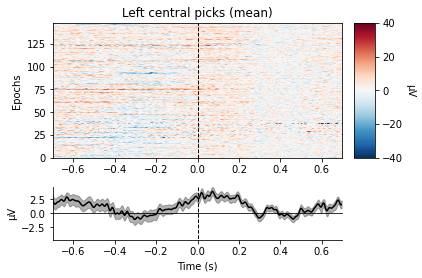

[<Figure size 432x288 with 3 Axes>]

In [22]:
leftcentralpicks = [5, 6, 10]
mne.viz.plot_epochs_image(epochs, group_by={'Left central picks' : leftcentralpicks}, combine = 'mean', cmap = 'interactive', vmin=-40, vmax=40)

Now lets look into what causes these deflections. This is done by making a time-frequency analysis of the epochs. 

#### Time-Frequency analysis

In [23]:
#freqs = np.logspace(*np.log10([6, 35]), num=12)
freqs = np.arange(7, 30, 1)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc =  mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

#### Plotting Alpha waves

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


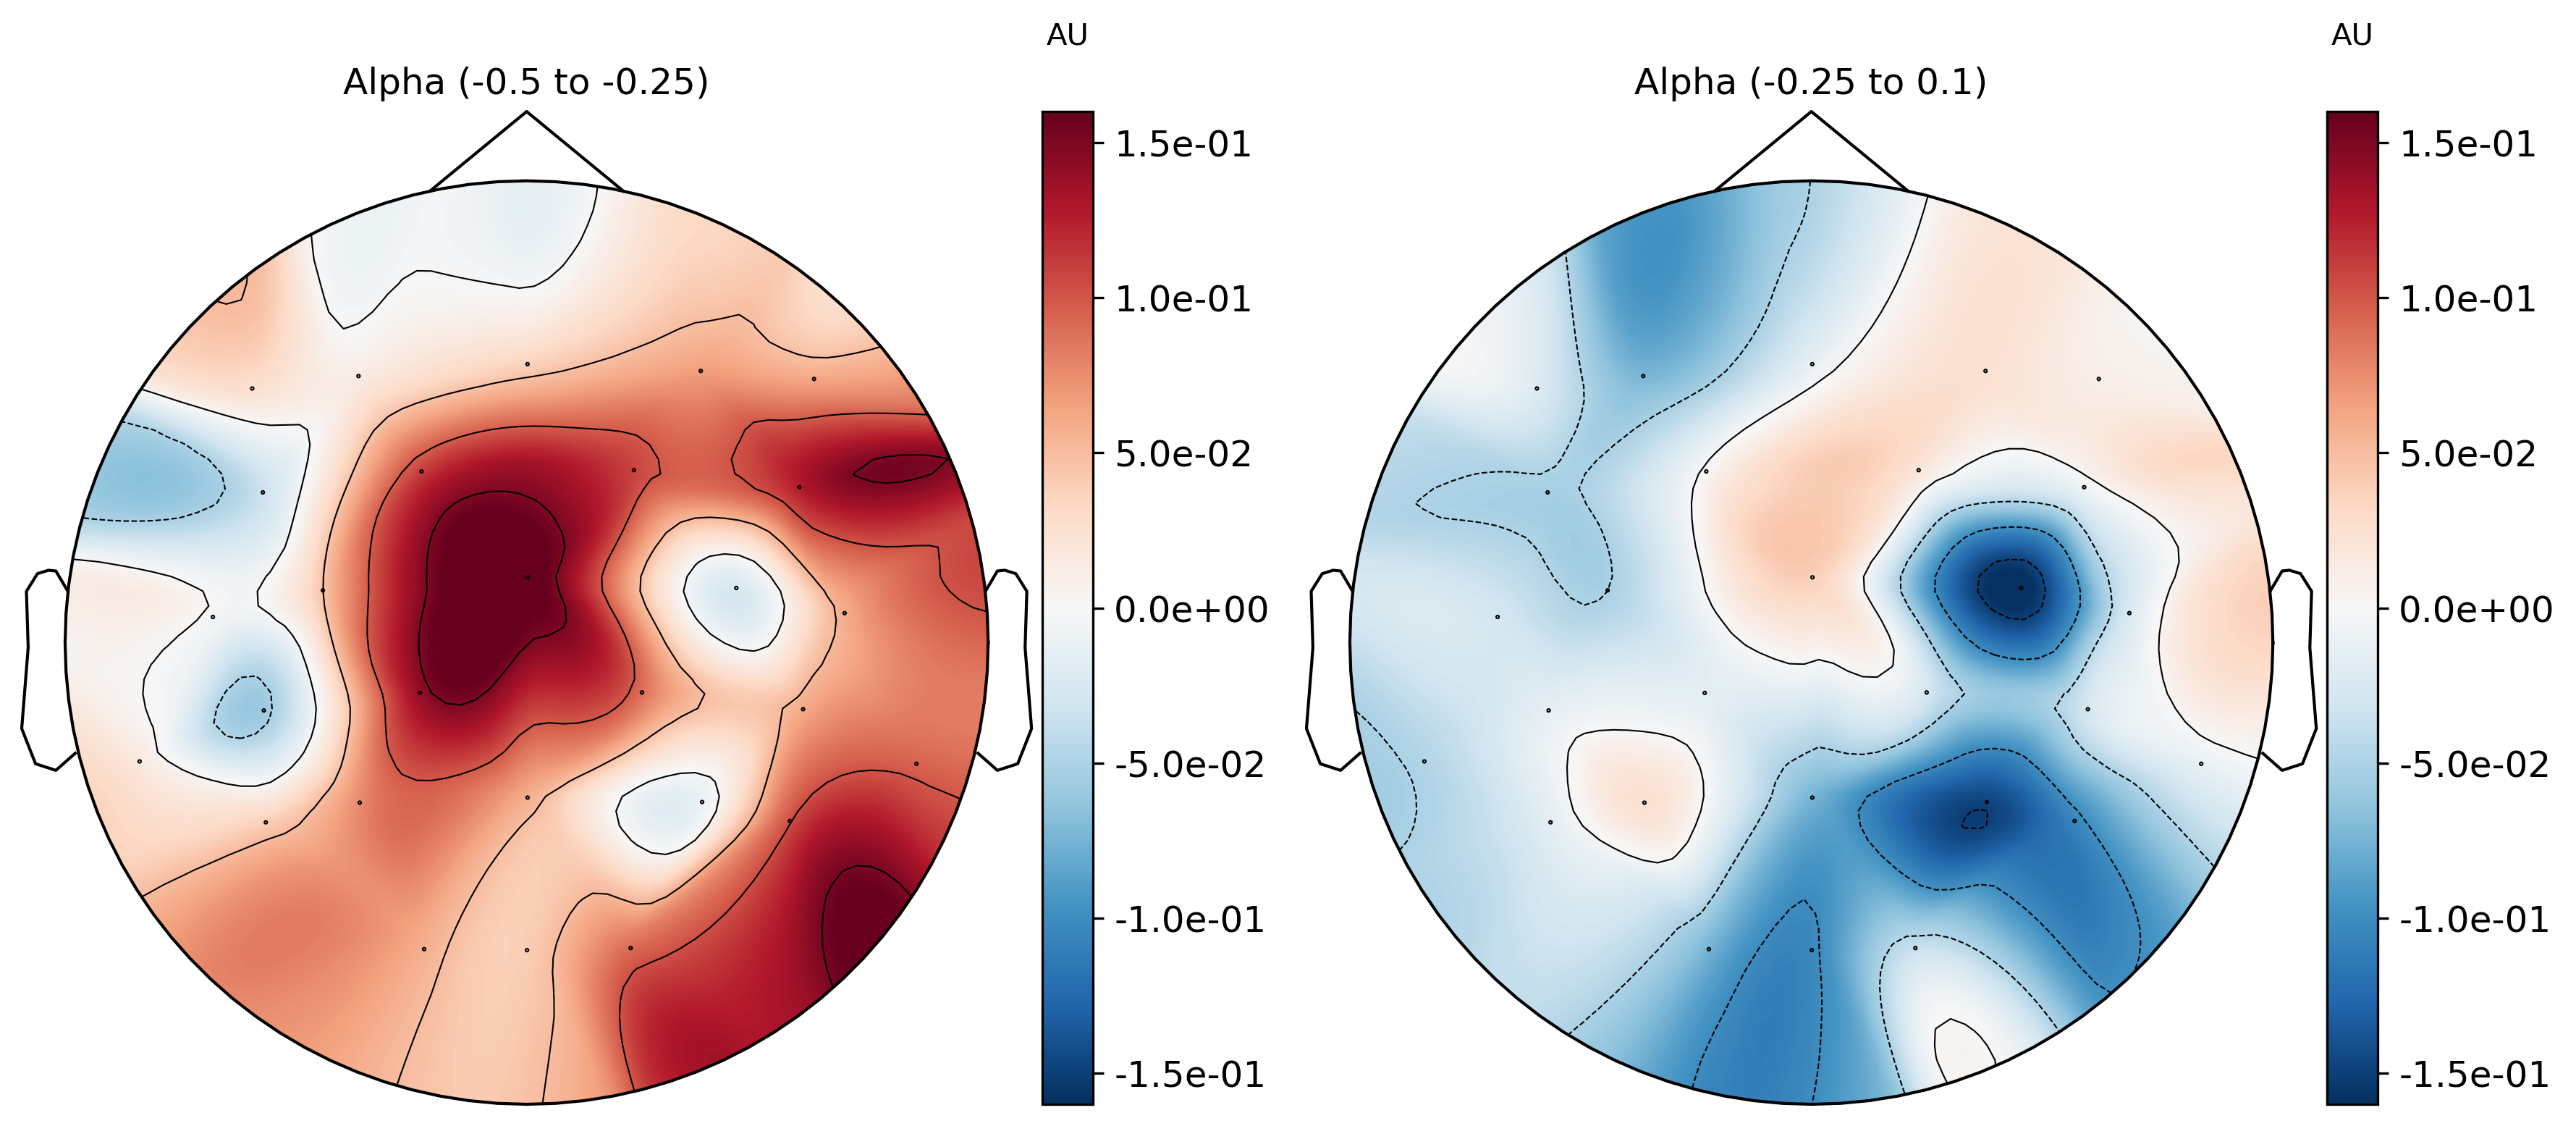

In [24]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6), dpi = 300)

baseline = (0.3, 0.5)
power.plot_topomap(ch_type='eeg', tmin=-0.5, tmax=-0.25, fmin=7, fmax=12,
                   baseline=baseline, mode='logratio', axes=axis[0],
                   title='Alpha (-0.5 to -0.25)', show=False, vmin = -.16, vmax = .16)

power.plot_topomap(ch_type='eeg', tmin=-0.25, tmax=0.1, fmin=7, fmax=12,
                   baseline=baseline, mode='logratio', axes=axis[1],
                   title='Alpha (-0.25 to 0.1)', show=False, vmin = -.16, vmax = .16)

mne.viz.tight_layout()
plt.savefig('figures/time_frequency_alpha_topomaps.png')
plt.show()

Applying baseline correction (mode: mean)


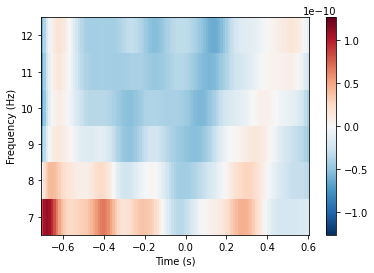

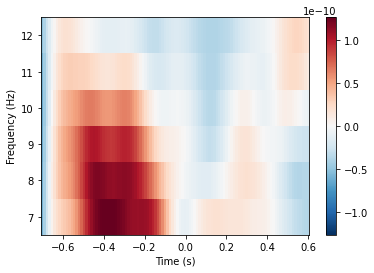

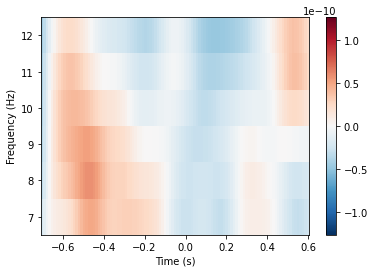

In [25]:
leftcentralpicks = [5, 6, 10]
# NOTE:See if we can take some kind of average to include all channels in one plot???
power.plot(mode='mean', picks = leftcentralpicks,baseline = (0.3, 0.5), tmin = -.7, tmax = .6, fmin = 7, fmax = 12);

We see that the alpha waves are reduced just before and while the action is done and then rebounds afterwards. alpha waves "locks" a given network in a dominating rhythm, and when this rhythm is supressed it opens up for other processing in the given area (i.e, initiating a motor action).

#### Plotting beta rhythms

Applying baseline correction (mode: mean)


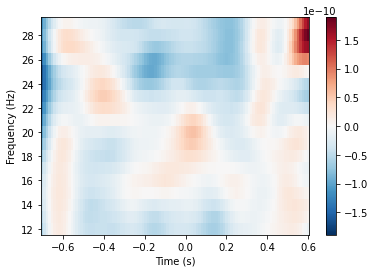

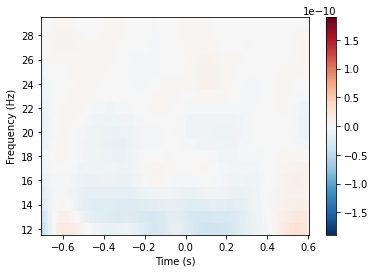

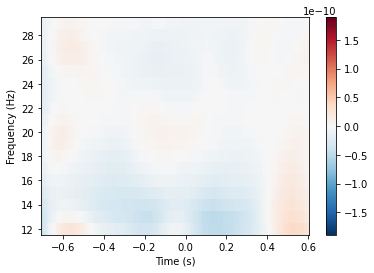

In [26]:
power.plot(mode='mean', picks = leftcentralpicks,baseline = (0.3, 0.5), tmin = -.7, tmax = .6, fmin = 12, fmax = 30);

#### Contrasting across conditions
How to understand this? higher inhibition of motor reponse??? Super interesting if that is the case.


**Link to code:**
https://berdakh.github.io/blog/eeg/jupyter/2020/09/14/MNE-Tutorial-part-2.html#Time-Frequency-stuff

In [27]:
n_cycles = freqs / 2.  # different number of cycle per frequency
power_inc, itc_inc =  mne.time_frequency.tfr_morlet(epochs['cInc'], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, n_jobs=1)
power_con, itc_con =  mne.time_frequency.tfr_morlet(epochs['cCon'], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, n_jobs=1)
power_neu, itc_neu =  mne.time_frequency.tfr_morlet(epochs['cNeu'], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, n_jobs=1)
power_all, itc_all =  mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, n_jobs=1)

## Comparison of mean power in the conditions

**Alpha rhythms**
7-12 Hz

**Lower beta rhythms**
12-18 Hz

**Higher beta rhytms**
18-30 Hz

In [28]:
freq_ind_b = 0
freq_ind_a = 5
time_ind_b = 70
time_ind_a = 300


## averaging over alpha frequencies
average_con = hf.average_power_time(power_con, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
average_inc = hf.average_power_time(power_inc, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
average_neu = hf.average_power_time(power_neu, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)


freq_ind_b = 5
freq_ind_a = 11

## averaging over low beta frequencies
average_con_low = hf.average_power_time(power_con, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
average_inc_low = hf.average_power_time(power_inc, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
average_neu_low = hf.average_power_time(power_neu, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)

freq_ind_b = 11
freq_ind_a = 22

## averaging over high beta frequencies
#average_con_high = hf.average_power_time(power_con, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
#average_inc_high = hf.average_power_time(power_inc, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
#average_neu_high = hf.average_power_time(power_neu, leftcentralpicks, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)

In [29]:
times = power_con.times[time_ind_b:time_ind_a]

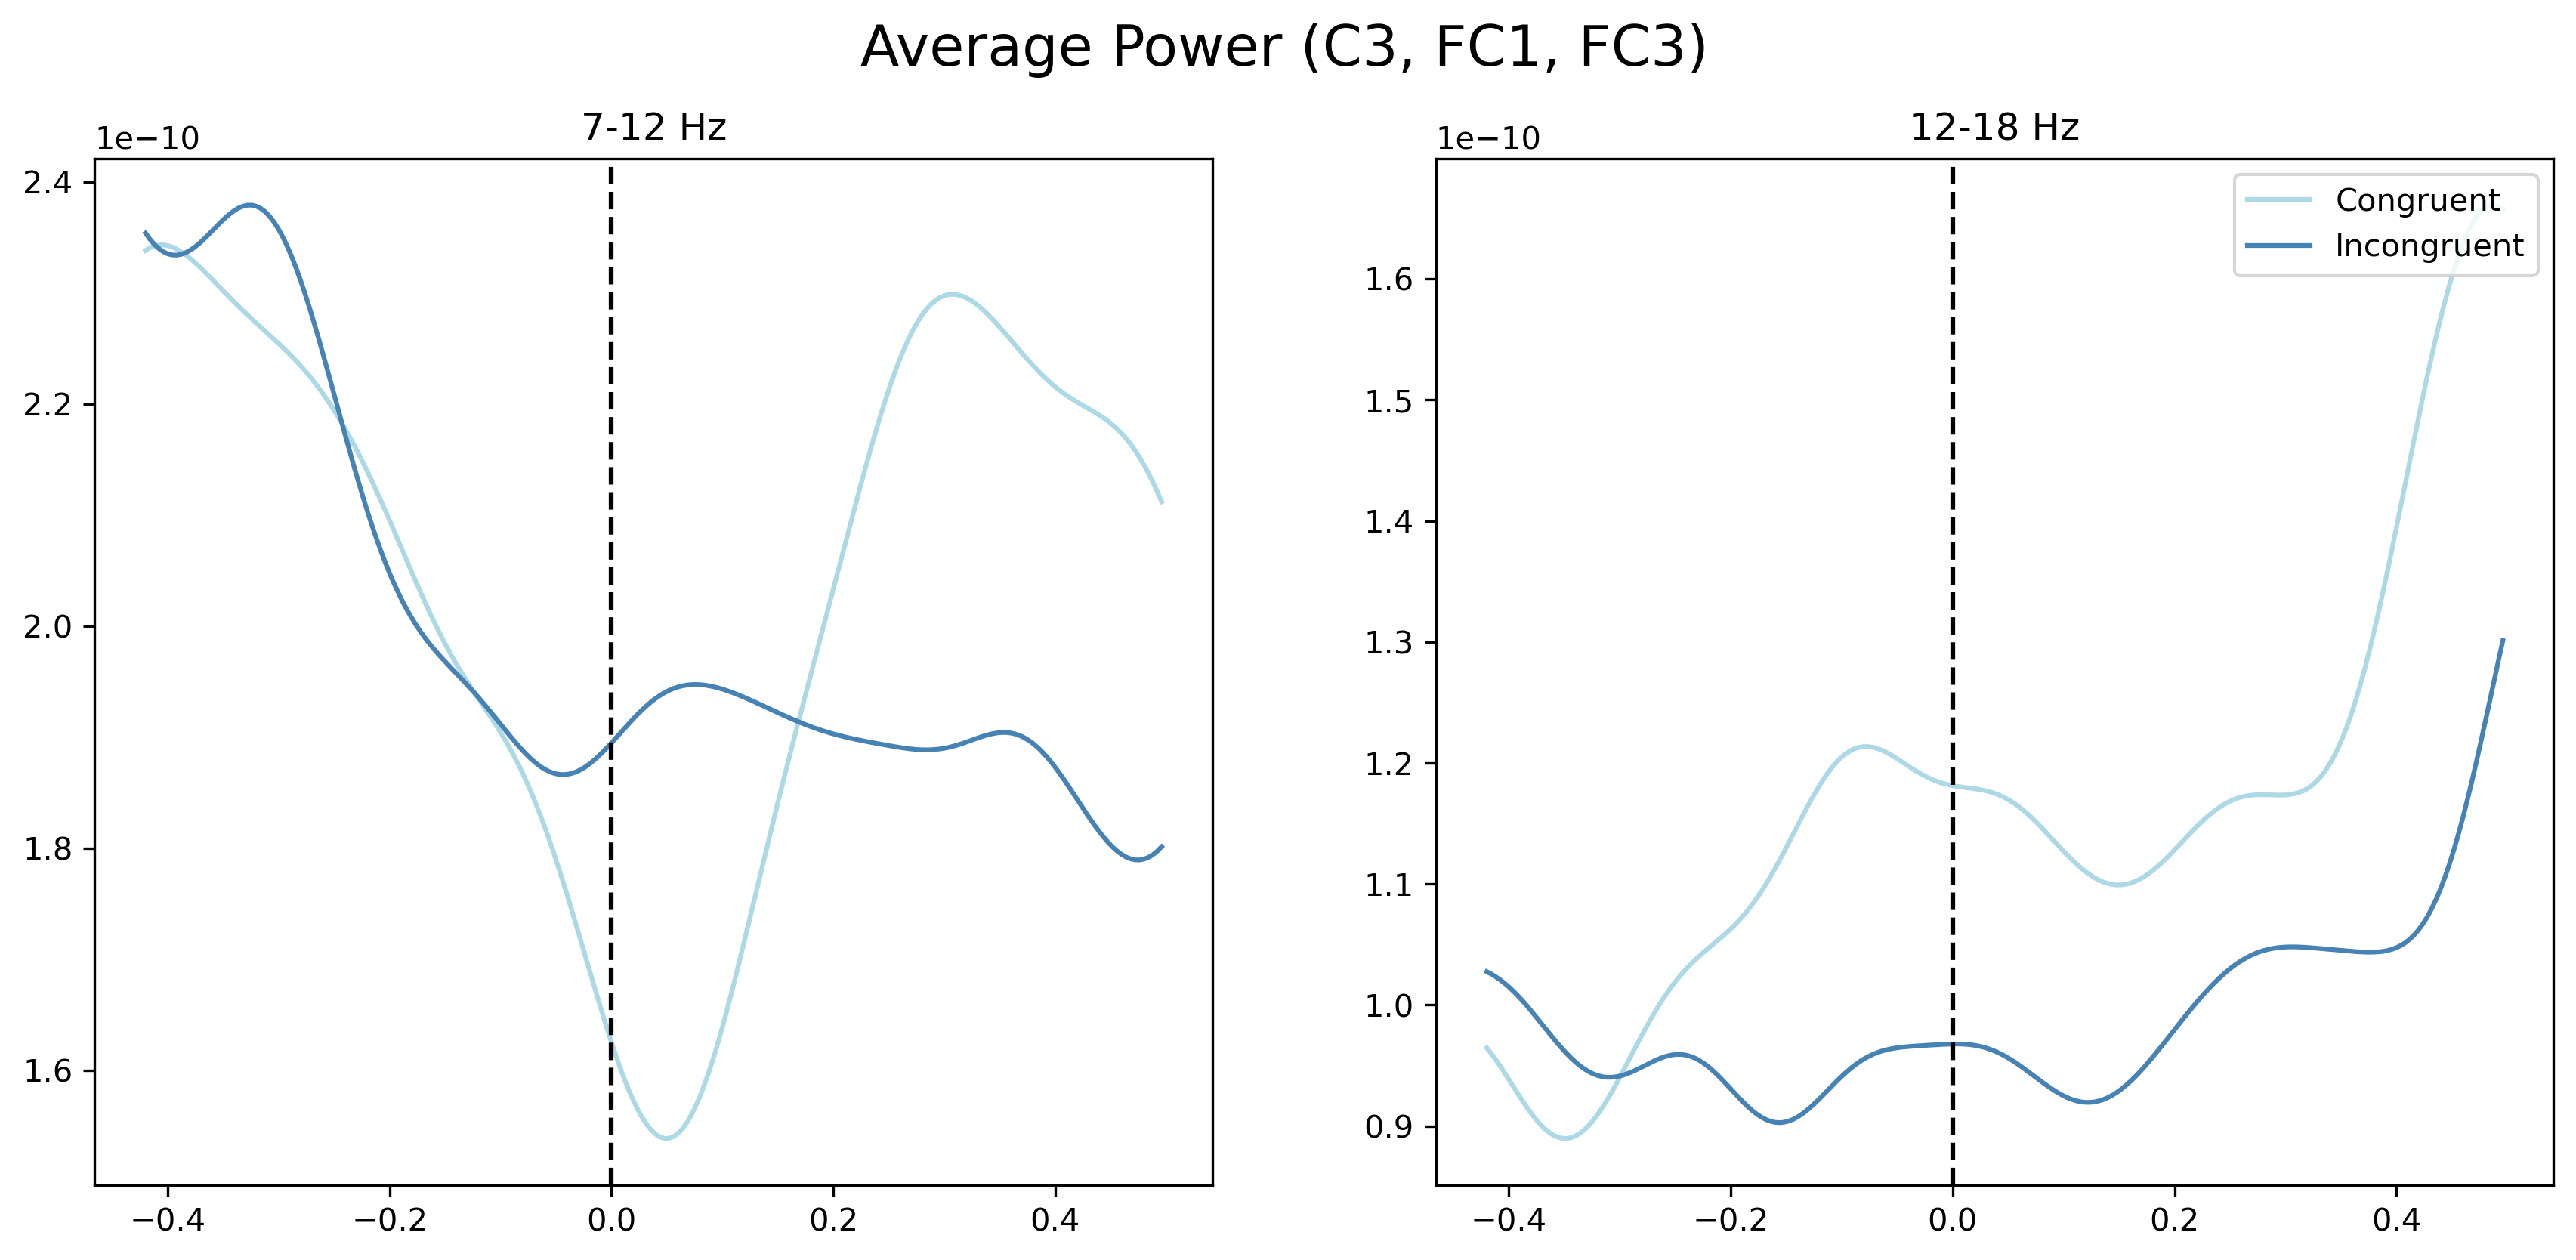

In [30]:
fig, axis = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axis[0].plot(times, average_con, 'lightblue', label = 'Congruent')
axis[0].plot(times, average_inc, 'steelblue', label = 'Incongruent')
axis[0].axvline(x=0.0, color='black', linestyle='--')
axis[0].title.set_text('7-12 Hz')

axis[1].plot(times, average_con_low, 'lightblue', label = 'Congruent')
axis[1].plot(times, average_inc_low, 'steelblue', label = 'Incongruent')
axis[1].title.set_text('12-18 Hz')
axis[1].axvline(x=0.0, color='black', linestyle='--')
axis[1].legend(loc = 'upper right')

#axis[2].plot(times, average_con_high, 'steelblue', label = 'Congruent')
#axis[2].plot(times, average_inc_high, 'lightblue', label = 'Incongruent')
#axis[2].legend(loc = 'upper right')
#axis[2].title.set_text('18-30 Hz')

fig.suptitle('Average Power (C3, FC1, FC3)', fontsize=18)
fig.savefig('figures/average_power_time.png')

## Cluster-based permutation test on tfr

https://mne.tools/stable/generated/mne.stats.permutation_cluster_test.html

**Notes:** The null hypothesis of this test is that the time frequency representation in the experimental conditions arise from the same probability distribution. Multiple factors influence this type of test, like the signal-to-noise ratio, the threshold chosen to select samples to belong to a cluster and the number of trials. 

In [31]:
baseline = (0.3, 0.5)

**Note:** Data should have shape (observations, frequencies, channels/vertices)

In [32]:
epochs_power = list()
for condition in [epochs[k] for k in ('cCon', 'cInc')]:
    this_tfr = tfr_morlet(condition, freqs, n_cycles=n_cycles, average=False, return_itc=False)
    this_tfr.apply_baseline(mode='ratio', baseline=baseline)
    epochs_power.append(this_tfr.data)

# transpose again to (epochs, times, frequencies, vertices)
X = [np.transpose(x, (0, 3, 2, 1)) for x in epochs_power]

Not setting metadata
Applying baseline correction (mode: ratio)
Not setting metadata
Applying baseline correction (mode: ratio)


In [33]:
X[0].shape

(49, 350, 23, 28)

Adjacency matrix!

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 28
<class 'scipy.sparse.csr.csr_matrix'>


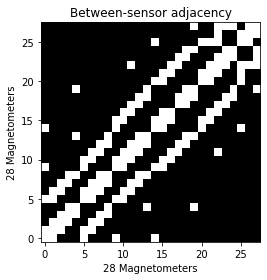

In [34]:
adjacency, ch_names = find_ch_adjacency(epochs.info, ch_type='eeg')

print(type(adjacency))  # it's a sparse matrix!

fig, ax = plt.subplots(figsize=(5, 4))
ax.imshow(adjacency.toarray(), cmap='gray', origin='lower',
          interpolation='nearest')
ax.set_xlabel('{} Magnetometers'.format(len(ch_names)))
ax.set_ylabel('{} Magnetometers'.format(len(ch_names)))
ax.set_title('Between-sensor adjacency')
fig.tight_layout()

tfr_adjacency = combine_adjacency(
    len(freqs), len(this_tfr.times), adjacency)

THIS DOES NOT WORK

In [35]:
F_obs, clusters, p_values, _ = spatio_temporal_cluster_test(
    X, n_permutations=1000, tail=1, n_jobs=1, adjacency=tfr_adjacency)

ValueError: too many values to unpack (expected 3)

This does work but not sure what it does 

In [ ]:
F_obs, clusters, p_values, _ = permutation_cluster_test(
    X, n_permutations = 1000, tail = 1, n_jobs = 1, adjacency = tfr_adjacency)

Using a threshold of 3.939126
stat_fun(H1): min=0.000000 max=23.420053
Running initial clustering
Found 3660 clusters
Permuting 999 times...


100%|██████████|  : 999/999 [13:49<00:00,    1.20it/s]

Computing cluster p-values
Done.


In [ ]:
p_accept = 0.05
good_cluster_inds = np.where(p_values < p_accept)[0]
print(good_cluster_inds)

for i in good_cluster_inds:
    print(clusters[i])

[]


### Code trash can :)))))))

TypeError: Invalid shape (350, 23, 28) for image data

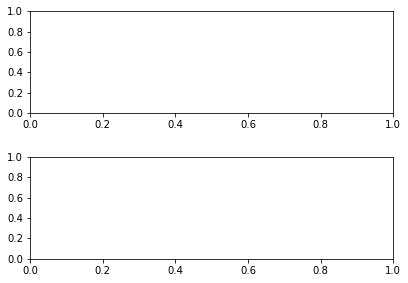

In [ ]:
times = 1e3 * epochs_congruent.times  # change unit to ms

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

# Compute the difference in evoked to determine which was greater since
# we used a 1-way ANOVA which tested for a difference in population means
evoked_power_1 = X[0].mean(axis=0)
evoked_power_2 = X[1].mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
signs = np.sign(evoked_power_contrast)

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, p_values):
    if p_val <= 0.05:
        F_obs_plot[c] = F_obs[c] * signs[c]

ax.imshow(F_obs,
          extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower', cmap='gray')
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(F_obs_plot,
          extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower', cmap='RdBu_r',
          vmin=-max_F, vmax=max_F)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Induced power ({ch_name})')

# plot evoked
evoked_condition_1 = epochs_congruent.average()
evoked_condition_2 = epochs_incongruent.average()
evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2],
                                     weights=[1, -1])
evoked_contrast.plot(axes=ax2, time_unit='s')